# EDA


- The os module has a perfect method to list files in a directory.
- Pandas json normalize could work here but is not necessary to convert the JSON data to a dataframe.
- You may need a nested for-loop to access each sale!
- We've put a lot of time into creating the structure of this repository, and it's a good example for future projects.  In the file functions_variables.py, there is an example function that you can import and use.  If you have any variables, functions or classes that you want to make, they can be put in the functions_variables.py file and imported into a notebook.  Note that only .py files can be imported into a notebook. If you want to import everything from a .py file, you can use the following:
```python
from functions_variables import *
```
If you just import functions_variables, then each object from the file will need to be prepended with "functions_variables"\
Using this .py file will keep your notebooks very organized and make it easier to reuse code between notebooks.

In [48]:
import pandas as pd
import numpy as np
import os
import json
from pprint import pprint
from dotenv import load_dotenv
import warnings
import sys
import seaborn as sns
sys.path.append(r'notebooks/python_scripts')
from API_calls import *
from data_importing_cleaning import *
from sub_df_creation import *

load_dotenv()
warnings.simplefilter(action='ignore', category=FutureWarning)

api_key=os.getenv('GOOGLE_API_KEY')

## Data Importing

Please see `data_importing_cleaning.py` for the full data import function. Below is an overview of the function.

Check all files in 'data/' that end with `.json` and normalize them.
Explode tags and encode them. Drop 'tags' column and join new tag columns.
Convert dtypes.
Drop all 'property_id' dupes, keeping only the first one.
Rename columns.
Drop all columns that aren't needed.



In [49]:
# # Import and pickle raw df
# # Import and pickle raw df
# df = JSON_import(r'data/')
# df.to_pickle('data/!raw_df.pkl')

df= pd.read_pickle('data/!raw_df.pkl')
# Cleaning data
# df= cleaning_data(df)
# df.to_pickle('data/!cleaned_df.pkl')


# load pickled df
df= pd.read_pickle('data/!cleaned_df.pkl')
busstops = pd.read_pickle('data/!busstops.pkl')

## Data Cleaning and Wrangling

At this point, ensure that you have all sales in a dataframe.
- Take a quick look at your data (i.e. `.info()`, `.describe()`) - what do you see?
- Is each cell one value, or do some cells have lists?
- What are the data types of each column?
- Some sales may not actually include the sale price (target).  These rows should be dropped.
- There are a lot of NA/None values.  Should these be dropped or replaced with something?
    - You can drop rows or use various methods to fills NA's - use your best judgement for each column 
    - i.e. for some columns (like Garage), NA probably just means no Garage, so 0
- Drop columns that aren't needed
    - Don't keep the list price because it will be too close to the sale price. Assume we want to predict the price of houses not yet listed

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1795 entries, 3300959879 to 6663763535
Columns: 169 entries, baseball to address
dtypes: float64(2), object(167)
memory usage: 2.3+ MB


In [13]:
df.describe()

,coords_lon,coords_lat
count,1739.000000,1739.000000
mean,-92.295251,38.995983
std,16.028479,4.424493
min,-157.810583,21.277707
25%,-104.973856,35.683726
50%,-89.347261,39.697299
75%,-78.611225,41.832309
max,-71.006343,58.396178


Please see `data_importing_cleaning.py` for the full data cleaning function. Below is an overview of the function.

WILL UPDATE ONCE LANDON IS NONE HIS PASS

Please see `data_importing_cleaning.py` for the full missing data function. Below is an overview of the function.

Input some missing data that are easily findable.
Drop all rows that are missing address and coordinates.


WILL UPDATE ONCE LANDON IS NONE HIS PASS

### Dealing with Tags

Consider the fact that with tags, there are a lot of categorical variables.
- How many columns would we have if we OHE tags, city and state?
- Perhaps we can get rid of tags that have a low frequency.

In [14]:
# OHE categorical variables/ tags here
# tags will have to be done manually

### Dealing with Cities

- Sales will vary drastically between cities and states.  Is there a way to keep information about which city it is without OHE?
- Could we label encode or ordinal encode?  Yes, but this may have undesirable effects, giving nominal data ordinal values.
- What we can do is use our training data to encode the mean sale price by city as a feature (a.k.a. Target Encoding)
    - We can do this as long as we ONLY use the training data - we're using the available data to give us a 'starting guess' of the price for each city, without needing to encode city explicitly
- If you replace cities or states with numerical values (like the mean price), make sure that the data is split so that we don't leak data into the training selection. This is a great time to train test split. Compute on the training data, and join these values to the test data
- Note that you *may* have cities in the test set that are not in the training set. You don't want these to be NA, so maybe you can fill them with the overall mean

In [15]:
# perform train test split here
# do something with state and city

## Extra Data - STRETCH

> This doesn't need to be part of your Minimum Viable Product (MVP). We recommend you write a functional, basic pipeline first, then circle back and join new data if you have time

> If you do this, try to write your downstream steps in a way it will still work on a dataframe with different features!

- You're not limited to just using the data provided to you. Think/ do some research about other features that might be useful to predict housing prices. 
- Can you import and join this data? Make sure you do any necessary preprocessing and make sure it is joined correctly.
- Example suggestion: could mortgage interest rates in the year of the listing affect the price? 

In [ ]:
# import, join and preprocess new data here
#busstops= bus_query_by_lat_long(df)
busstops = pd.read_pickle('data/!busstops.pkl')


In [51]:
# Putting in df
df = df.merge(busstops, left_index=True, right_index=True, how='left')


## EDA/ Visualization

Remember all of the EDA that you've been learning about?  Now is a perfect time for it!
- Look at distributions of numerical variables to see the shape of the data and detect outliers.    
    - Consider transforming very skewed variables
- Scatterplots of a numerical variable and the target go a long way to show correlations.
- A heatmap will help detect highly correlated features, and we don't want these.
    - You may have too many features to do this, in which case you can simply compute the most correlated feature-pairs and list them
- Is there any overlap in any of the features? (redundant information, like number of this or that room...)

#### Heatmap Corelation Check on Num Values

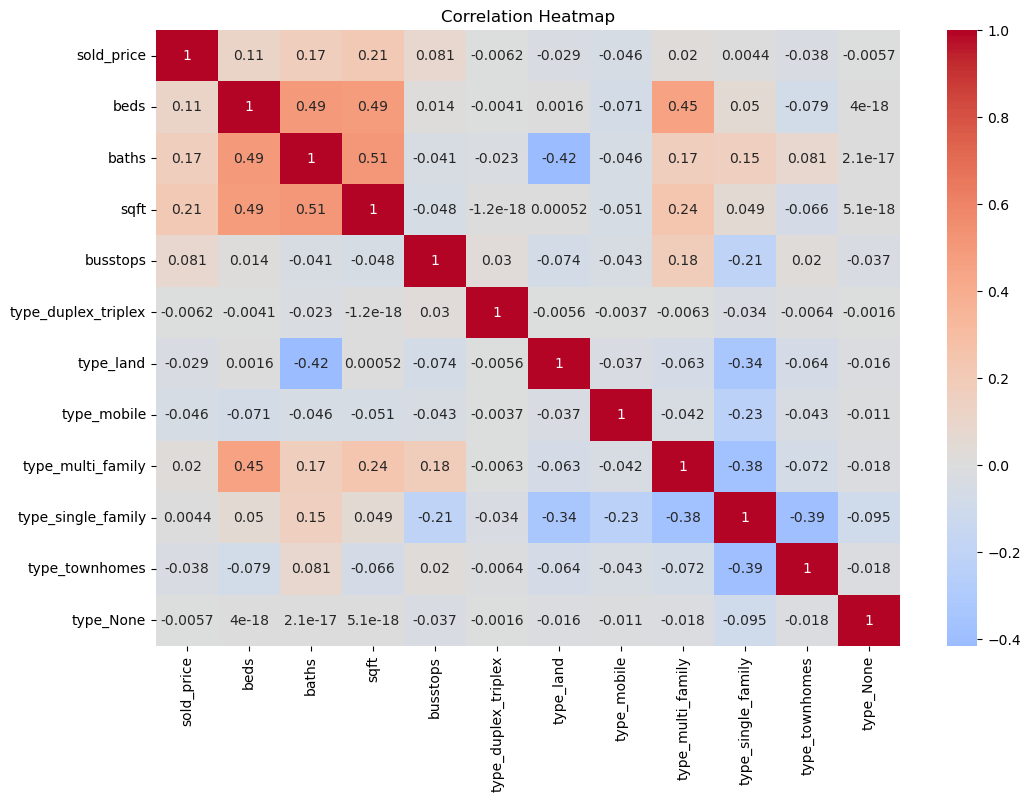

In [53]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
#set the paramaters 

num_cols_base = ['sold_price', 'beds', 'baths', 'sqft', 'busstops']
cat_cols_base = ['type']

#Build the pipelines
num_pipeline = Pipeline([("impude", SimpleImputer()), ("scale", StandardScaler())])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'))
])

# Combine with ColumnTransformer
preprocess = ColumnTransformer(transformers=[
    ('num_vals', num_pipeline, num_cols_base),
    ('cat_vals', cat_pipeline, cat_cols_base)
]) 
#transform the data
x_transformed = preprocess.fit_transform(df)


cat_encoded_cols = preprocess.named_transformers_["cat_vals"]["ohe"].get_feature_names_out(cat_cols_base)

all_columns = num_cols_base + list(cat_encoded_cols)

transformed_df = pd.DataFrame(x_transformed, columns=all_columns)
corr_matrix = transformed_df.corr()
#plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

### Histogram plots

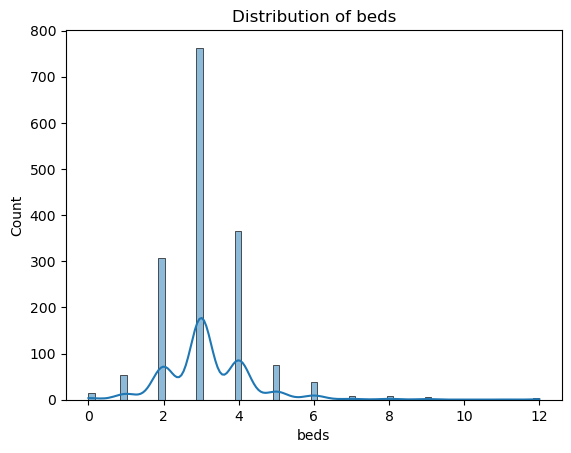

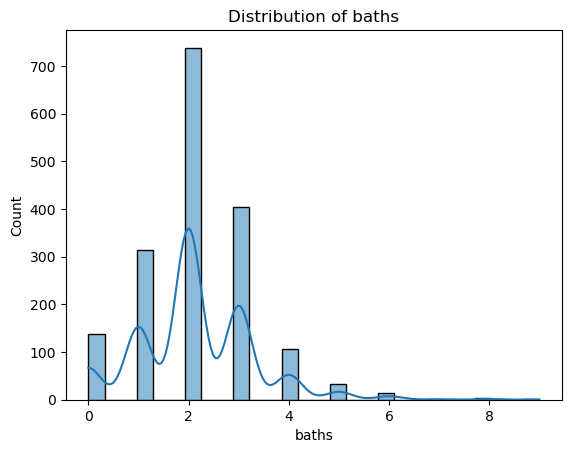

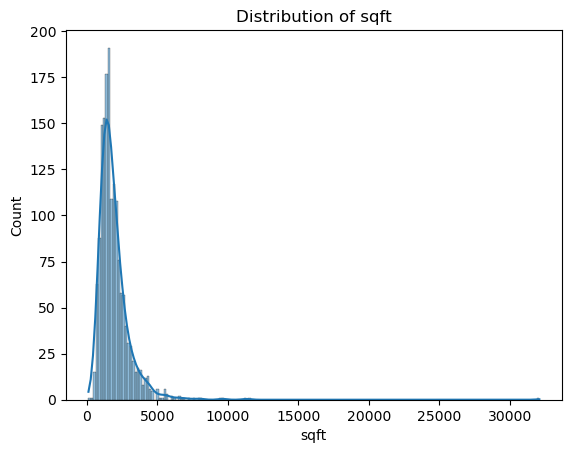

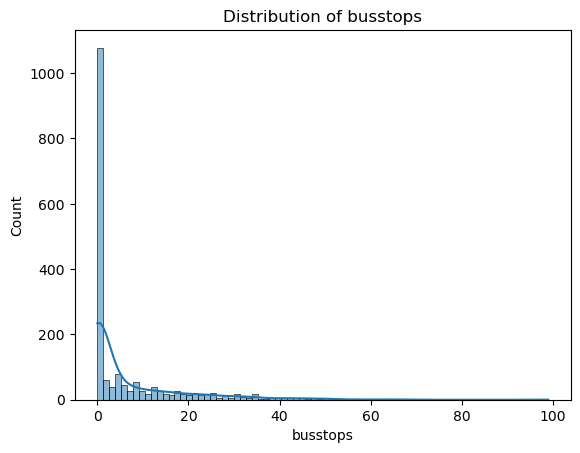

In [54]:
num_df = df[num_cols_base]

for col in num_df:
    if col != 'sold_price':
        # Plot distribution
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.show()

### Box Plots

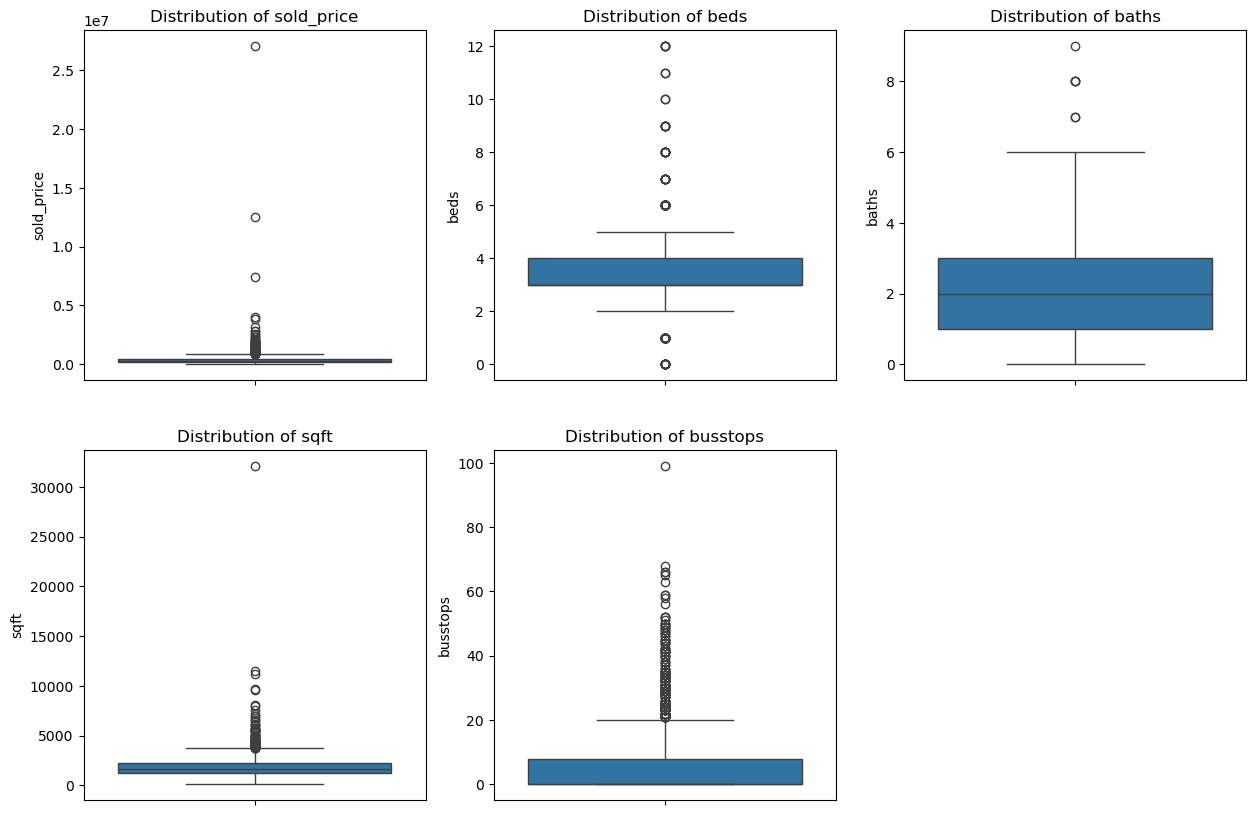

In [55]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Plot box plots for each numerical column
for i, col in enumerate(num_cols_base, 1):
    plt.subplot(2, 3, i)  
    sns.boxplot(data=df, y=col)
    plt.title(f'Distribution of {col}')

plt.show()

## Scaling and Finishing Up

Now is a great time to scale the data and save it once it's preprocessed.
- You can save it in your data folder, but you may want to make a new `processed/` subfolder to keep it organized

In [ ]:
df

,property_id,baseball,basement,basketball,basketball_court,beach,beautiful_backyard,big_bathroom,big_lot,big_yard,...,beds,type,zip_code,state,coords_lon,coords_lat,city,address,street_view_url,county
0,9074430767,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.000000,single_family,99801,Alaska,-134.593720,58.363950,Juneau,9453 Herbert Pl,https://maps.googleapis.com/maps/api/streetvie...,Juneau
1,9424983842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.207043,single_family,99801,Alaska,-92.285176,38.996694,Juneau,8477 Thunder Mountain Rd,https://maps.googleapis.com/maps/api/streetvie...,Juneau
3,9479068516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.207043,single_family,99801,Alaska,-92.285176,38.996694,Juneau,4515 Glacier Hwy,https://maps.googleapis.com/maps/api/streetvie...,Juneau
6,9879331943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.207043,single_family,99801,Alaska,-92.285176,38.996694,Juneau,17850 Point Stephens Rd,https://maps.googleapis.com/maps/api/streetvie...,Juneau
10,9521639574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.207043,single_family,99801,Alaska,-92.285176,38.996694,Juneau,9951 Stephen Richards Memorial Dr,https://maps.googleapis.com/maps/api/streetvie...,Juneau
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38363,4542127284,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.000000,single_family,25314,West Virginia,-81.644994,38.341576,Charleston,1008 Oakmont Rd,https://maps.googleapis.com/maps/api/streetvie...,Kanawha
38368,3895826397,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.000000,single_family,25387,West Virginia,-81.661662,38.377371,Charleston,1041 Temple St,https://maps.googleapis.com/maps/api/streetvie...,Kanawha
38373,4941005485,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.000000,single_family,25314,West Virginia,-81.659885,38.338617,Charleston,238 Oakwood Rd,https://maps.googleapis.com/maps/api/streetvie...,Kanawha
38378,4306867390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,single_family,25302,West Virginia,-81.644214,38.363038,Charleston,408 Lee St W,https://maps.googleapis.com/maps/api/streetvie...,Kanawha
